In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from river import evaluate
from river import metrics

from river import stream, compose, drift
from river import preprocessing
from river import optim
from river import linear_model as ln
%matplotlib inline

In [2]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Alteration_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Label']))
X = df.drop(['Label'], axis=1)
y = df['Label']
X, y = shuffle(X, y, random_state=42)
dataset = stream.iter_pandas(X, y)

Original dataset shape  Counter({0: 14269, 1: 922})


In [3]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [4]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

CPU times: user 1.47 s, sys: 6.86 ms, total: 1.48 s
Wall time: 1.47 s


           Precision   Recall   F1       Support  
                                                  
       0      99.75%   81.67%   89.81%     14269  
       1      25.45%   96.85%   40.31%       922  
                                                  
   Macro      62.60%   89.26%   65.06%            
   Micro      82.59%   82.59%   82.59%            
Weighted      95.24%   82.59%   86.80%            

                 82.59% accuracy                  

In [5]:
dataset = stream.iter_pandas(X, y)

In [6]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=100
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('# Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Alteration_EHMS.png')
    plt.close()

    return fig

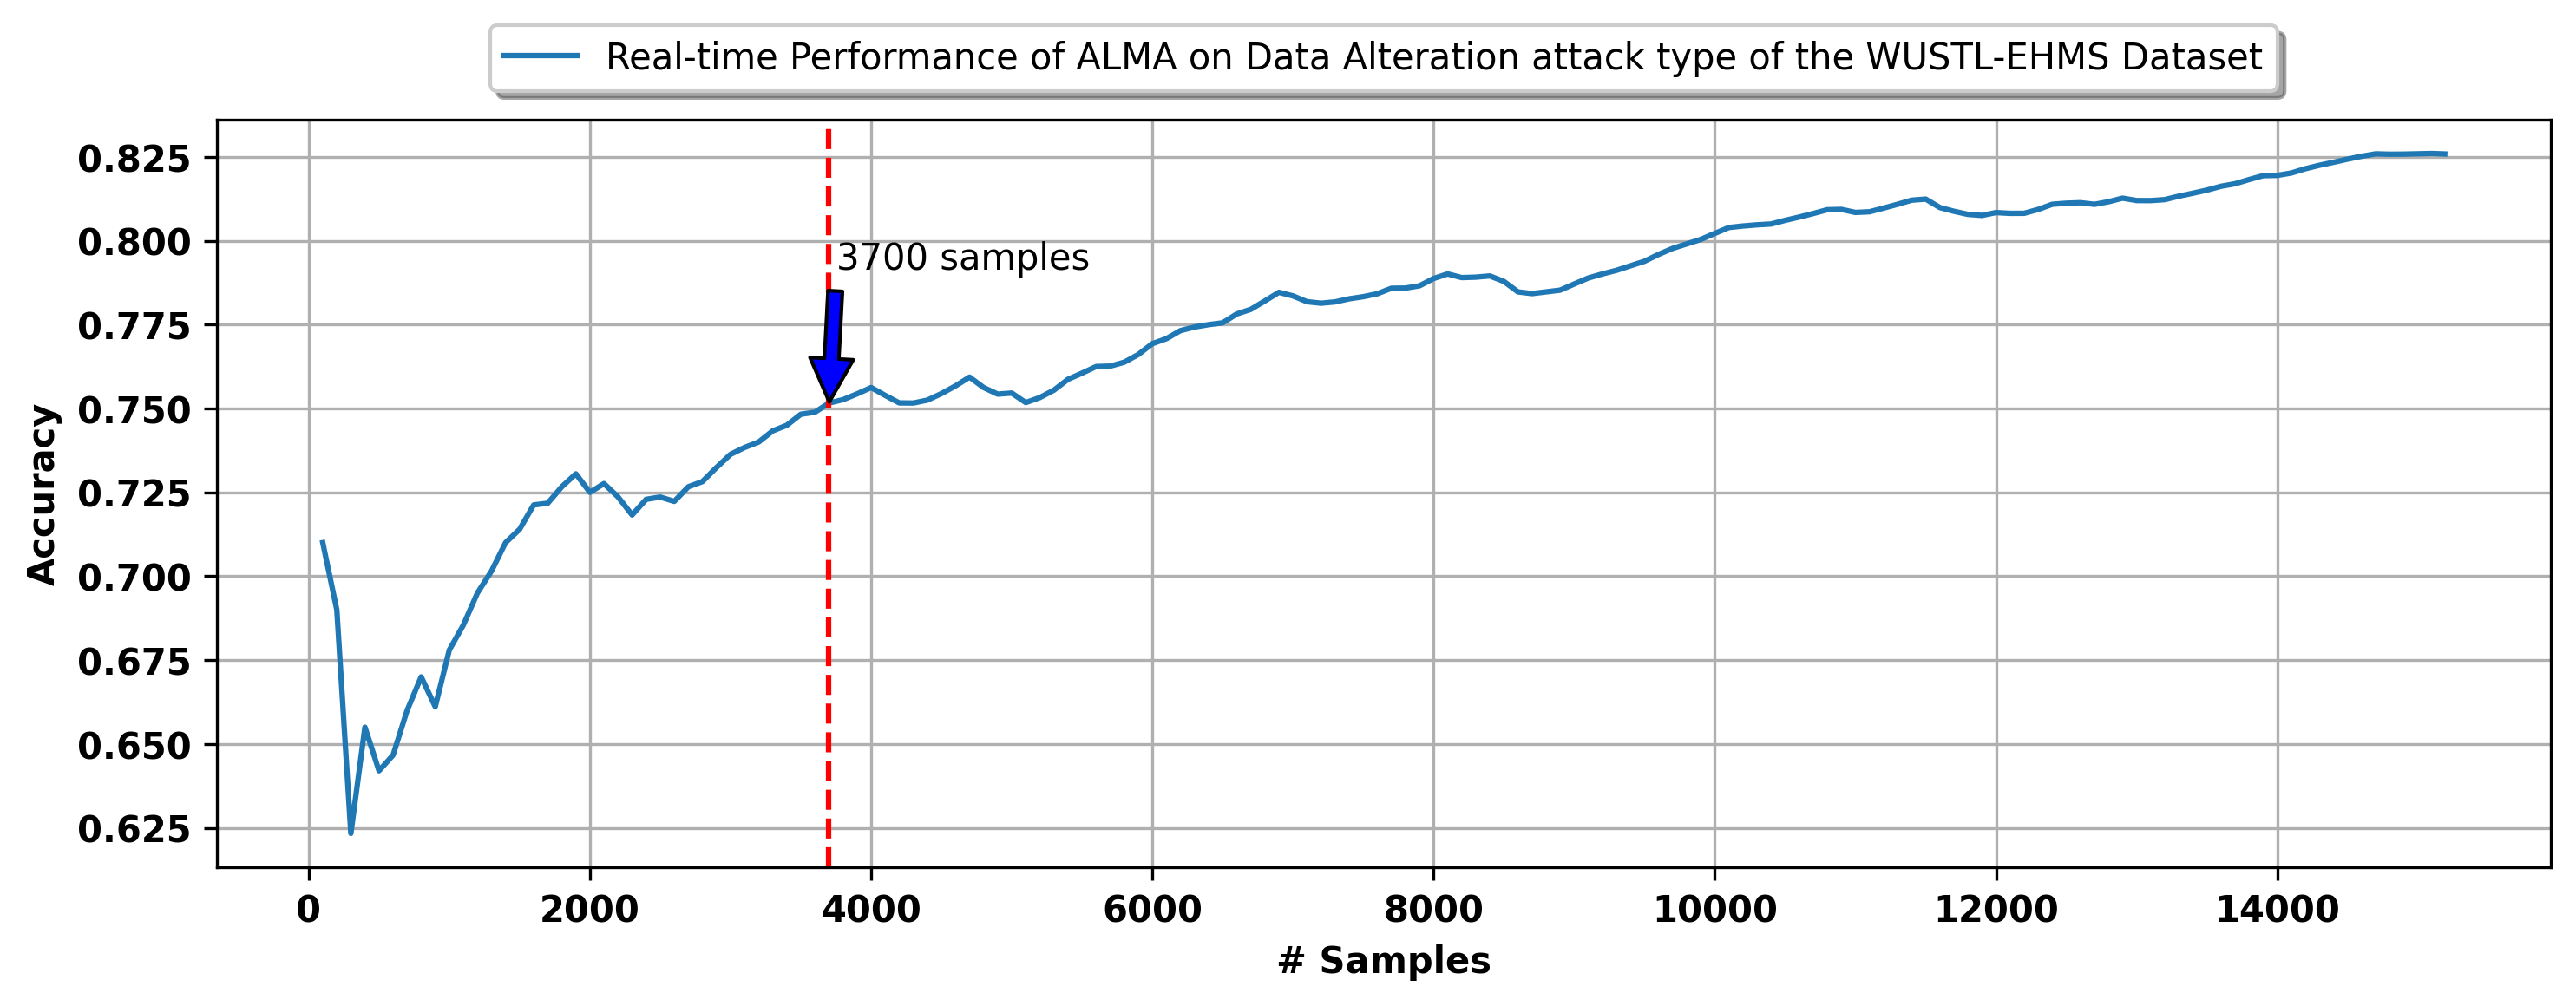

In [7]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of ALMA on Data Alteration attack type of the WUSTL-EHMS Dataset": (
            preprocessing.StandardScaler() |ln.ALMAClassifier(alpha=0.1, B=4.6)
        )
    }
)

In [8]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Spoofing_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Label']))
X = df.drop(['Label'], axis=1)
y = df['Label']
X, y = shuffle(X, y, random_state=42)
dataset = stream.iter_pandas(X, y)

Original dataset shape  Counter({0: 14269, 1: 1124})


In [9]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [10]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

CPU times: user 1.56 s, sys: 26.7 ms, total: 1.59 s
Wall time: 1.57 s


           Precision   Recall   F1       Support  
                                                  
       0      92.93%   54.34%   68.58%     14269  
       1       7.58%   47.51%   13.07%      1124  
                                                  
   Macro      50.25%   50.93%   40.82%            
   Micro      53.84%   53.84%   53.84%            
Weighted      86.70%   53.84%   64.53%            

                 53.84% accuracy                  

In [11]:
dataset = stream.iter_pandas(X, y)

In [12]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=100
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('# Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Spoofing_EHMS.png')
    plt.close()

    return fig

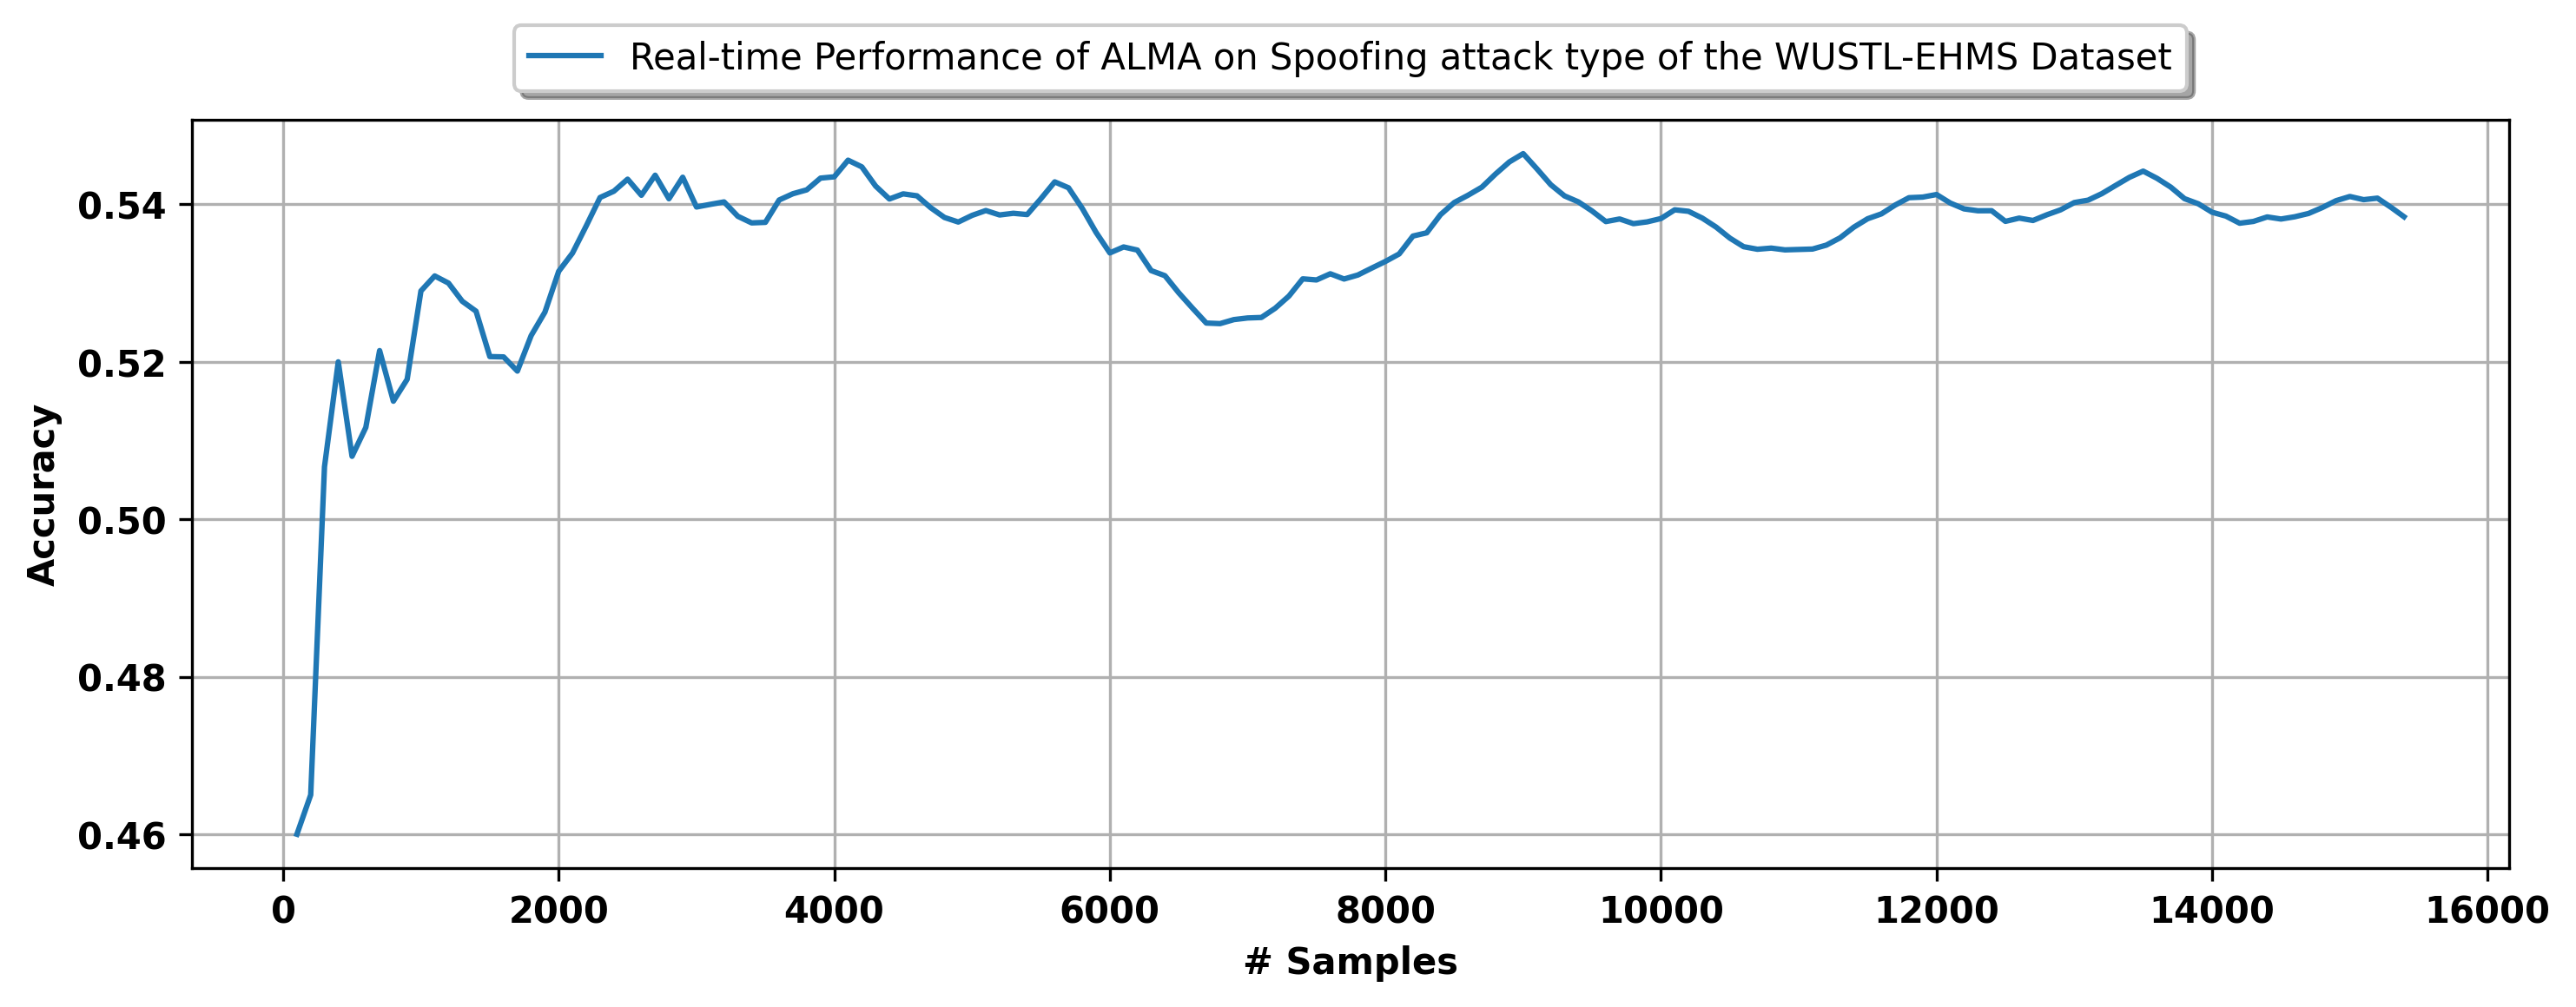

In [13]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of ALMA on Spoofing attack type of the WUSTL-EHMS Dataset": (
            preprocessing.StandardScaler() |ln.ALMAClassifier(alpha=0.1, B=4.6)
        )
    }
)

In [14]:
#Loading the dataset
df = pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Benign_Only.csv")
df1= pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Alteration_Only.csv")
df2= pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Spoofing_Only.csv")
X = df.drop(['Label'], axis=1)
y = df['Label']
X1 = df1.drop(['Label'], axis=1)
y1 = df1['Label']
X2 = df2.drop(['Label'], axis=1)
y2 = df2['Label']
X3 = pd.concat([X, X1, X2])
y3 = pd.concat([y, y1, y2])
X3, y3 = shuffle(X3, y3, random_state=42)
dataset = stream.iter_pandas(X3, y3)

In [15]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [16]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

CPU times: user 1.66 s, sys: 16.6 ms, total: 1.67 s
Wall time: 1.73 s


           Precision   Recall   F1       Support  
                                                  
       0      92.47%   79.41%   85.44%     14269  
       1      27.65%   54.89%   36.78%      2046  
                                                  
   Macro      60.06%   67.15%   61.11%            
   Micro      76.33%   76.33%   76.33%            
Weighted      84.34%   76.33%   79.34%            

                 76.33% accuracy                  

In [17]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Spoofing_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Label']))
X = df.drop(['Label'], axis=1)
y = df['Label']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({0: 14269, 1: 1124})


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=100, stratify=df['Label'] )

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [19]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

CPU times: user 84 ms, sys: 2.44 ms, total: 86.4 ms
Wall time: 86.2 ms


           Precision   Recall   F1       Support  
                                                  
       0      91.39%   53.80%   67.73%       710  
       1       6.55%   38.98%   11.22%        59  
                                                  
   Macro      48.97%   46.39%   39.48%            
   Micro      52.67%   52.67%   52.67%            
Weighted      84.88%   52.67%   63.39%            

                 52.67% accuracy                  

In [20]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 95% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 95% unseen samples
Accuracy: 0.6645240700218819
Precision: 0.06282722513089005
Recall: 0.2591549295774648
F1_Score: 0.10113594723341882


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=100, stratify=df['Label'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [22]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

CPU times: user 165 ms, sys: 4.05 ms, total: 169 ms
Wall time: 167 ms


           Precision   Recall   F1       Support  
                                                  
       0      93.32%   57.22%   70.94%      1440  
       1       6.10%   40.40%   10.60%        99  
                                                  
   Macro      49.71%   48.81%   40.77%            
   Micro      56.14%   56.14%   56.14%            
Weighted      87.71%   56.14%   67.06%            

                 56.14% accuracy                  

In [23]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 90% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 90% unseen samples
Accuracy: 0.6401039411000433
Precision: 0.06785948068950469
Recall: 0.30341463414634146
F1_Score: 0.11091298145506419


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=100, stratify=df['Label'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [25]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

CPU times: user 235 ms, sys: 4.56 ms, total: 239 ms
Wall time: 236 ms


           Precision   Recall   F1       Support  
                                                  
       0      94.39%   57.51%   71.47%      2165  
       1       6.98%   48.25%   12.19%       143  
                                                  
   Macro      50.68%   52.88%   41.83%            
   Micro      56.93%   56.93%   56.93%            
Weighted      88.97%   56.93%   67.80%            

                 56.93% accuracy                  

In [26]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 85% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 85% unseen samples
Accuracy: 0.6320978219335116
Precision: 0.0872280852896834
Recall: 0.41284403669724773
F1_Score: 0.14402560455192037


In [27]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EHMS/EHMS_Alteration_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Label']))
X = df.drop(['Label'], axis=1)
y = df['Label']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({0: 14269, 1: 922})


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=100, stratify=df['Label'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [29]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

CPU times: user 76.7 ms, sys: 1.9 ms, total: 78.6 ms
Wall time: 77.4 ms


           Precision   Recall   F1       Support  
                                                  
       0      99.62%   73.77%   84.76%       709  
       1      20.51%   96.00%   33.80%        50  
                                                  
   Macro      60.07%   84.88%   59.28%            
   Micro      75.23%   75.23%   75.23%            
Weighted      94.41%   75.23%   81.41%            

                 75.23% accuracy                  

In [30]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 95% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 95% unseen samples
Accuracy: 0.7362111973392461
Precision: 0.1851534005578202
Recall: 0.9896788990825688
F1_Score: 0.31194650280137354


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=100, stratify=df['Label'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [32]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

CPU times: user 153 ms, sys: 2.69 ms, total: 156 ms
Wall time: 154 ms


           Precision   Recall   F1       Support  
                                                  
       0      99.51%   71.43%   83.16%      1435  
       1      16.16%   94.05%   27.57%        84  
                                                  
   Macro      57.83%   82.74%   55.37%            
   Micro      72.68%   72.68%   72.68%            
Weighted      94.90%   72.68%   80.09%            

                 72.68% accuracy                  

In [33]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 90% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 90% unseen samples
Accuracy: 0.8654183733177296
Precision: 0.31179564237415475
Recall: 0.9904534606205251
F1_Score: 0.4742857142857142


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=100, stratify=df['Label'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [35]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

CPU times: user 226 ms, sys: 3.31 ms, total: 230 ms
Wall time: 227 ms


           Precision   Recall   F1       Support  
                                                  
       0      99.81%   72.48%   83.98%      2155  
       1      16.83%   97.56%   28.71%       123  
                                                  
   Macro      58.32%   85.02%   56.34%            
   Micro      73.84%   73.84%   73.84%            
Weighted      95.33%   73.84%   80.99%            

                 73.84% accuracy                  

In [36]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 85% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 85% unseen samples
Accuracy: 0.7779756834198095
Precision: 0.21624588364434688
Recall: 0.986232790988736
F1_Score: 0.3547152824668017


In [37]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EHMS/ehms.csv")
print('Original dataset shape  %s' % Counter(df['Label']))
X = df.drop(['Label'], axis=1)
y = df['Label']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({0: 14269, 1: 2046})


In [38]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

dataset = stream.iter_pandas(X, y)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [39]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      92.31%   76.64%   83.75%      4370  
       1      25.58%   55.71%   35.06%       630  
                                                  
   Macro      58.95%   66.18%   59.41%            
   Micro      74.00%   74.00%   74.00%            
Weighted      83.90%   74.00%   77.61%            

                 74.00% accuracy                   – 00:00:00 – 12.87 KB
[10,000]            Precision   Recall   F1       Support  
                                                  
       0      92.26%   79.74%   85.54%      8742  
       1      27.54%   53.50%   36.36%      1258  
                                                  
   Macro      59.90%   66.62%   60.95%            
   Micro      76.44%   76.44%   76.44%            
Weighted      84.12%   76.44%   79.36%            

                 76.44% accuracy                   – 00:00:00 – 12.87 KB
[15,000]           

           Precision   Recall   F1       Support  
                                                  
       0      92.31%   80.38%   85.93%     14269  
       1      28.03%   53.27%   36.73%      2046  
                                                  
   Macro      60.17%   66.83%   61.33%            
   Micro      76.98%   76.98%   76.98%            
Weighted      84.25%   76.98%   79.76%            

                 76.98% accuracy                  

In [40]:
dataset = stream.iter_pandas(X, y)

In [41]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=100
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('# Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Performance_ALMA_EHMS.png')
    plt.close()

    return fig

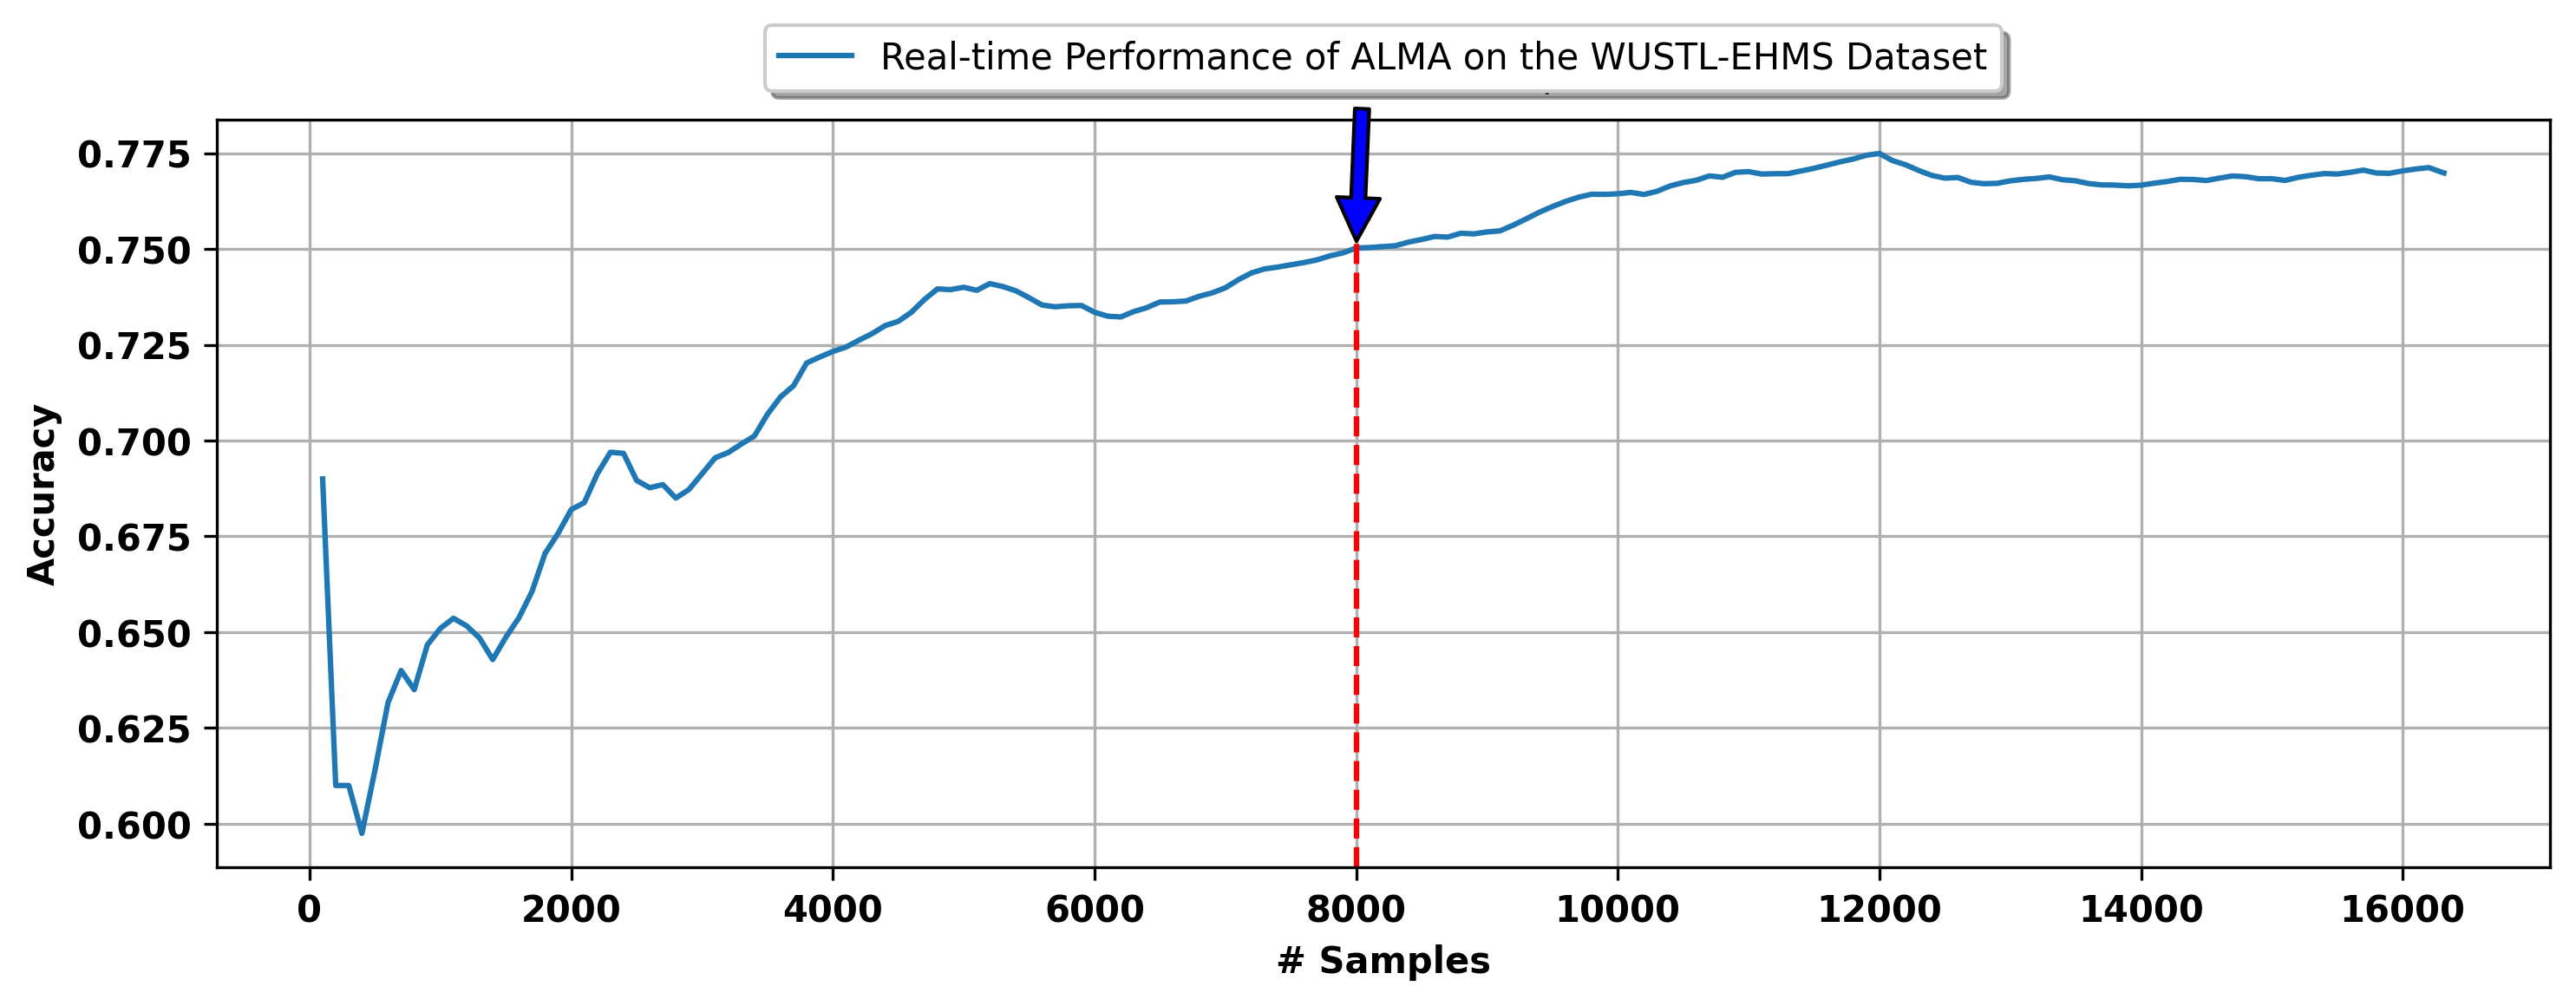

In [42]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of ALMA on the WUSTL-EHMS Dataset": (
            preprocessing.StandardScaler() |ln.ALMAClassifier(alpha=0.1, B=4.6)
        )
    }
)